In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize

from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
from scipy.interpolate import SmoothBivariateSpline

import os
import pickle

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 20})
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

In [3]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [4]:
cm = plt.cm.jet
cm.set_bad("white")

# constants and paths

In [5]:
Emin = 2.

In [63]:
pth = '../../../files/diff_xsec/'
plots_save_pth = '../../../plots/corrections/diff_xsec/comparisons/'
files_save_pth = '../../../files/diff_xsec/'

In [7]:
asp_r = 1./12.*6.

left, width = 0.23, 0.85
bottom, height = 0.09, 0.85
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect1 = [left*asp_r, bottom, height, height]
# rect2 = [left*asp_r, bottom, height, 0.2]

# read files

In [8]:
v = np.load(os.path.join(pth,'diff_xsec_vals.npy'))[0]

In [9]:
v.keys()

['iNuNC_genie',
 'lgE_genie',
 'one_weight_genie',
 'iNuBarCC_genie',
 'iNuCC_genie',
 'lgE_nugen',
 'iNuCC_nugen',
 'one_weight_nugen',
 'Y_genie',
 'Y_nugen',
 'iNuBarCC_nugen',
 'iNuBarNC_nugen',
 'iNuNC_nugen',
 'iNuBarNC_genie']

In [10]:
lgE_genie = v['lgE_genie']
lgE_nugen = v['lgE_nugen']

Y_genie = v['Y_genie']
Y_nugen = v['Y_nugen']

one_weight_genie = v['one_weight_genie']
one_weight_nugen = v['one_weight_nugen']

In [11]:
len(lgE_genie)

21799503

In [12]:
len(lgE_nugen)

50000000

In [13]:
iNuCC_genie = v['iNuCC_genie']
iNuBarCC_genie = v['iNuBarCC_genie']
iNuNC_genie = v['iNuNC_genie']
iNuBarNC_genie = v['iNuBarNC_genie']

iNuCC_nugen = v['iNuCC_nugen']
iNuBarCC_nugen = v['iNuBarCC_nugen']
iNuNC_nugen = v['iNuNC_nugen']
iNuBarNC_nugen = v['iNuBarNC_nugen']

In [14]:
tNuCC = 'NuMu CC'
tNuBarCC = 'NuMu Bar CC'
tNuCC_save = 'NuMu_CC_'
tNuBarCC_save = 'NuMu_Bar_CC_'

tNuNC = 'NuMu NC'
tNuBarNC = 'NuMu Bar NC'
tNuNC_save = 'NuMu_NC_'
tNuBarNC_save = 'NuMu_Bar_NC_'

# --------------------
# plots
# --------------------

In [32]:
nb = 50

In [79]:
def plot_comp(t, i_genie, i_nugen):
    
    # initial hists
    fig = plt.figure(1, figsize=(8, 6.2))
    ax = plt.gca()
    ax.set_aspect(2.)
    ax.set_title('GENIE: '+t)
    ax.set_xlabel('lg(E), GeV')
    ax.set_ylabel('y')

    h1g = ax.hist2d(lgE_genie[i_genie], Y_genie[i_genie], 
                   nb, [[Emin, 4.],[0., 1.]], 
                   weights=one_weight_genie[i_genie],
             cmap='jet', norm=LogNorm())

    plt.colorbar(h1[3], label='counts')
    save_name = 'diff_xsec_comp_GENIE_'+t.replace(' ', '_')
    plt.savefig(os.path.join(plots_save_pth,'not_norm',save_name+'.png'), dpi='figure')
    plt.savefig(os.path.join(plots_save_pth,'not_norm',save_name+'.pdf'), dpi='figure')
    plt.show()
    
    fig = plt.figure(1, figsize=(8, 6.2))
    ax = plt.gca()
    ax.set_aspect(2.)
    ax.set_title('CSMS (NUGEN): '+t)
    ax.set_xlabel('lg(E), GeV')
    ax.set_ylabel('y')

    h1n = ax.hist2d(lgE_nugen[i_nugen], Y_nugen[i_nugen], 
                   nb, [[Emin, 4.],[0., 1.]], 
                   weights=one_weight_nugen[i_nugen],
             cmap='jet', norm=LogNorm())

    plt.colorbar(h1[3], label='counts')
    save_name = 'diff_xsec_comp_NUGEN_'+t.replace(' ', '_')
    plt.savefig(os.path.join(plots_save_pth,'not_norm',save_name+'.png'), dpi='figure')
    plt.savefig(os.path.join(plots_save_pth,'not_norm',save_name+'.pdf'), dpi='figure')
    plt.show()

    # normalize per lg(E) bin
    h1g_norm = [h1g[0][i]/np.sum(h1g[0][i]) for i in range(nb)]
    h1n_norm = [h1n[0][i]/np.sum(h1n[0][i]) for i in range(nb)]
    h1g_norm = np.array(h1g_norm)
    h1n_norm = np.array(h1n_norm)

    vmin = np.min([np.min(h1g_norm), np.min(h1n_norm)])
    vmax = np.max([np.max(h1g_norm), np.max(h1n_norm)])
    
    # plot & save normed hists
    fig = plt.figure(1, figsize=(8, 6.2))
    ax = plt.gca()
    ax.set_aspect(2.)
    ax.set_title('GENIE: '+t)
    ax.set_xlabel('lg(E), GeV')
    ax.set_ylabel('y')

    p = plt.imshow(np.rot90(h1g_norm), extent=(2.,4.,0.,1.), aspect=2.,
               cmap='jet', norm=Normalize(vmin=vmin, vmax=vmax))

    plt.colorbar(p, label='counts (norm. to lg(E) bin)')
    
    save_name = 'diff_xsec_comp_GENIE_'+t.replace(' ', '_')
    plt.savefig(os.path.join(plots_save_pth,'norm_per_lgE_bin',save_name+'.png'), dpi='figure')
    plt.savefig(os.path.join(plots_save_pth,'norm_per_lgE_bin',save_name+'.pdf'), dpi='figure')
    plt.show()
    
    fig = plt.figure(1, figsize=(8, 6.2))
    ax = plt.gca()
    ax.set_aspect(2.)
    ax.set_title('CSMS (NUGEN): '+t)
    ax.set_xlabel('lg(E), GeV')
    ax.set_ylabel('y')

    p = plt.imshow(np.rot90(h1n_norm), extent=(2.,4.,0.,1.), aspect=2.,
               cmap='jet', norm=Normalize(vmin=vmin, vmax=vmax))

    plt.colorbar(p, label='counts (norm. to lg(E) bin)')
    
    save_name = 'diff_xsec_comp_NUGEN_'+t.replace(' ', '_')
    plt.savefig(os.path.join(plots_save_pth,'norm_per_lgE_bin',save_name+'.png'), dpi='figure')
    plt.savefig(os.path.join(plots_save_pth,'norm_per_lgE_bin',save_name+'.pdf'), dpi='figure')
    plt.show()

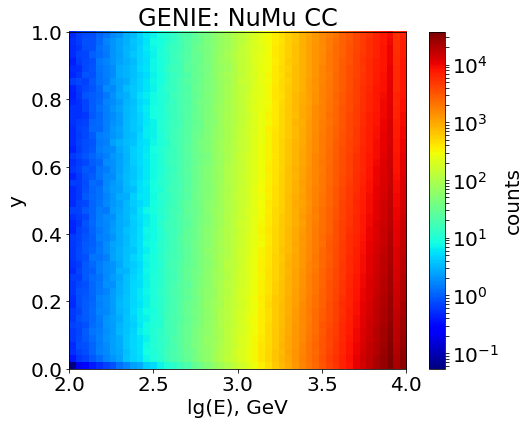

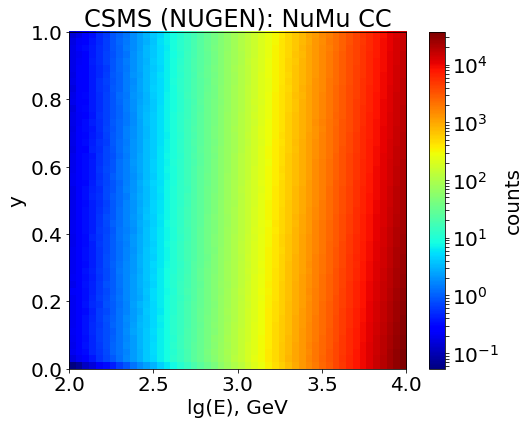

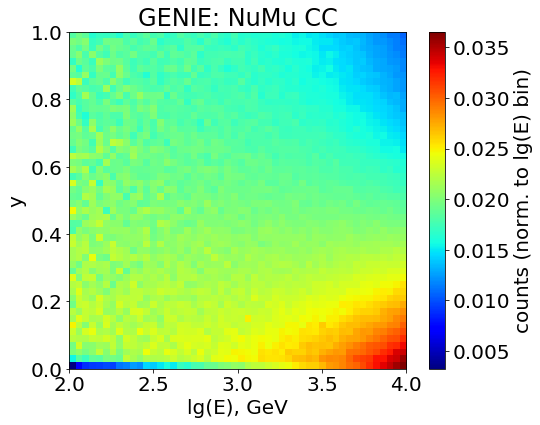

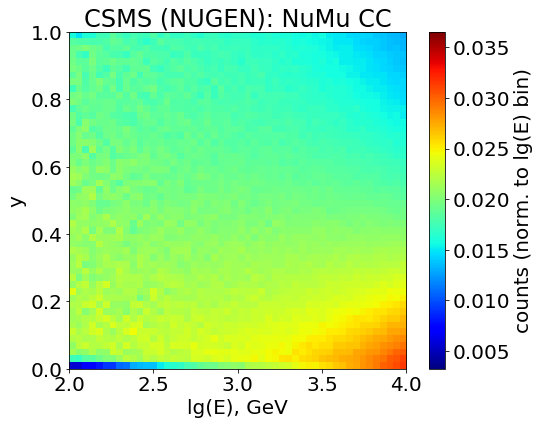

In [80]:
plot_comp(tNuCC, iNuCC_genie, iNuCC_nugen)

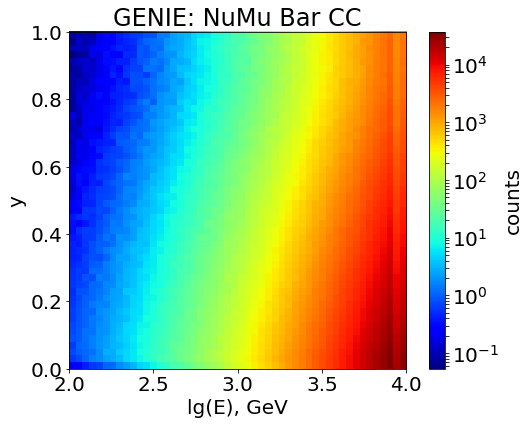

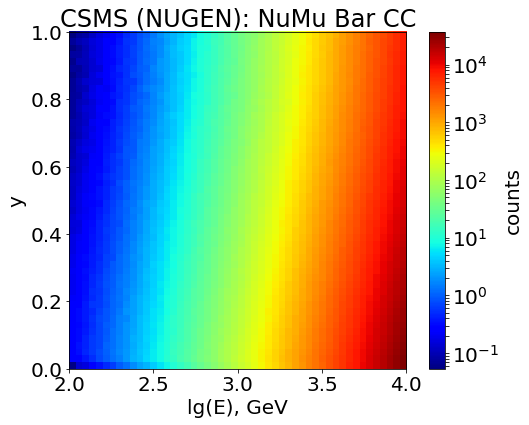

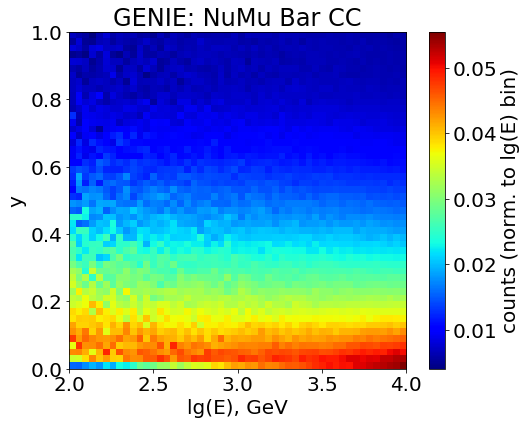

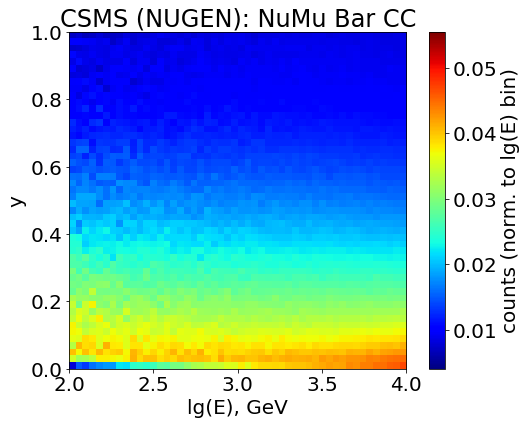

In [81]:
plot_comp(tNuBarCC, iNuBarCC_genie, iNuBarCC_nugen)

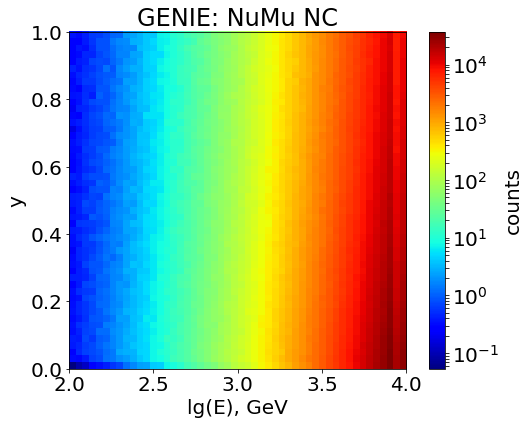

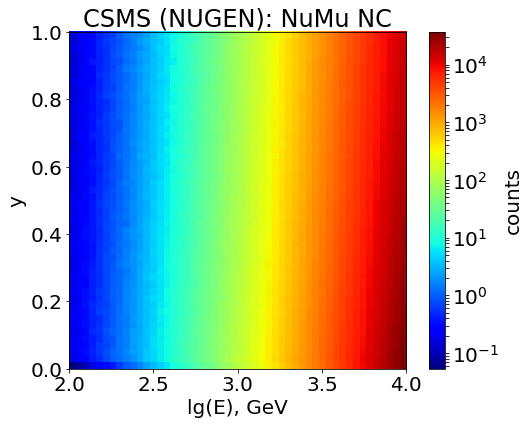

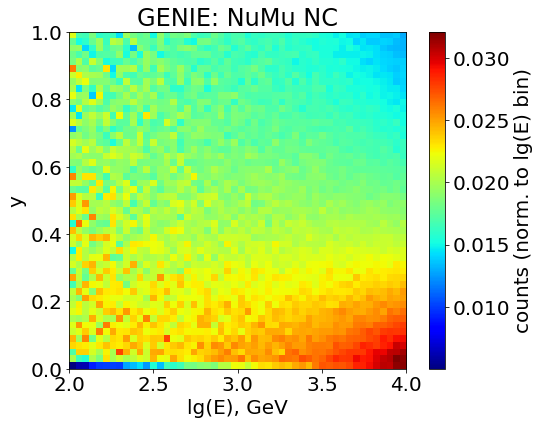

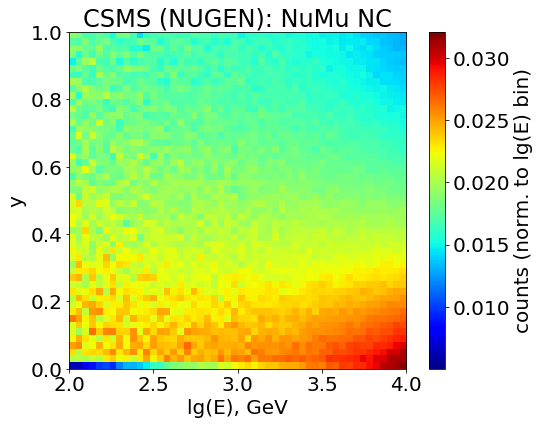

In [82]:
plot_comp(tNuNC, iNuNC_genie, iNuNC_nugen)

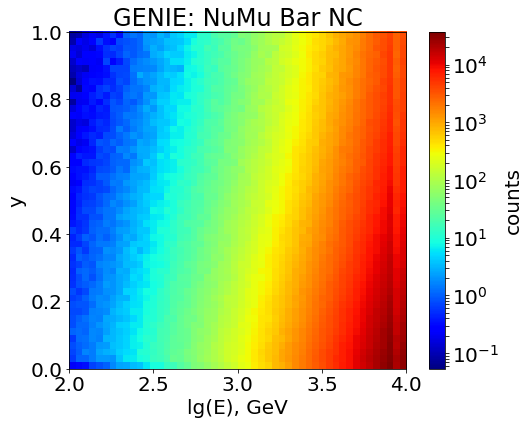

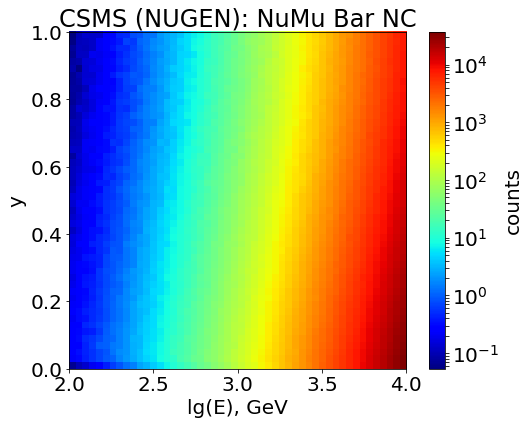

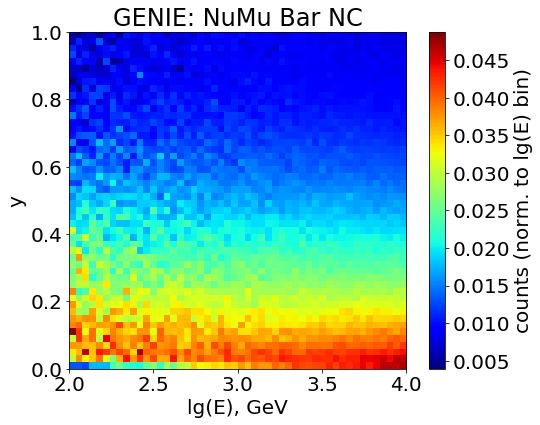

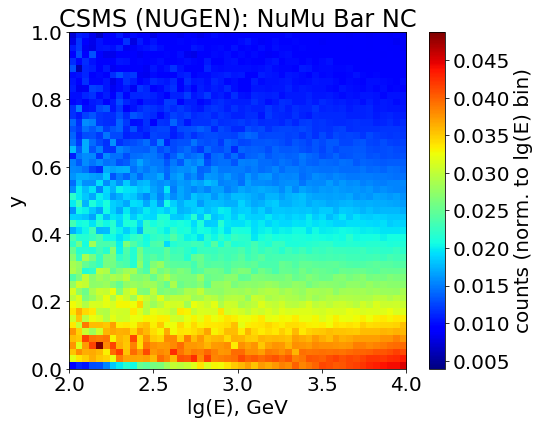

In [83]:
plot_comp(tNuBarNC, iNuBarNC_genie, iNuBarNC_nugen)

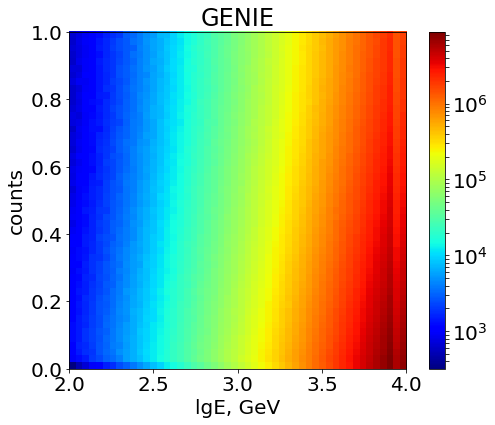

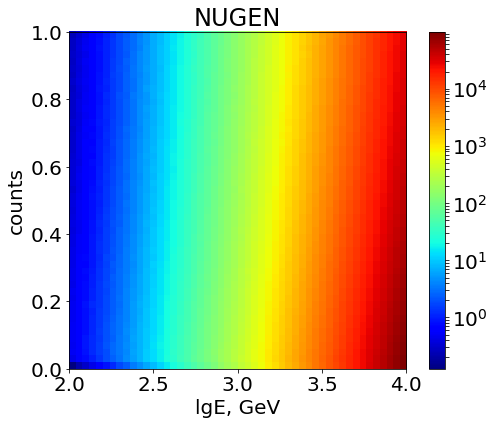

In [38]:
fig = plt.figure(1, figsize=(8, 6.2))

ax = plt.gca()
ax.set_aspect(2.)
ax.set_title('GENIE')
ax.set_xlabel('lgE, GeV')
ax.set_ylabel('counts')

h1 = ax.hist2d(lgE_genie, Y_genie, nb, [[Emin, 4.],[0., 1.]], weights=one_weight_genie,
         cmap='jet', norm=LogNorm())

plt.colorbar(h1[3])
plt.show()

fig = plt.figure(1, figsize=(8, 6.2))

ax = plt.gca()
ax.set_aspect(2.)
ax.set_title('NUGEN')
ax.set_xlabel('lgE, GeV')
ax.set_ylabel('counts')


h1 = ax.hist2d(lgE_nugen, Y_nugen, nb, [[Emin, 4.],[0., 1.]], weights=one_weight_nugen,
         cmap='jet', norm=LogNorm())

plt.colorbar(h1[3])
plt.show()

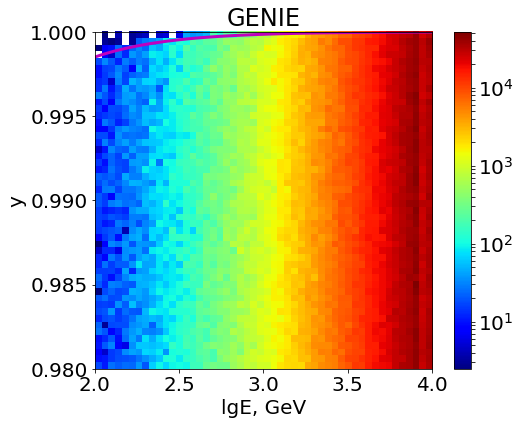

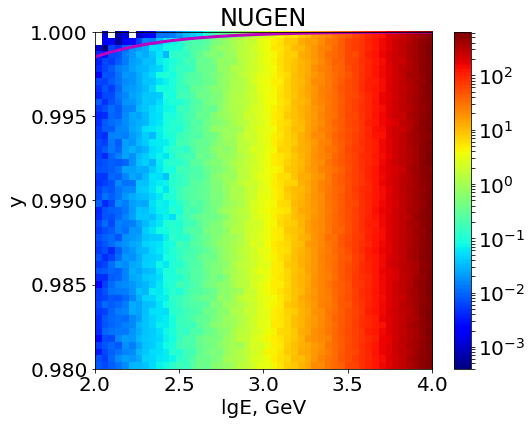

In [33]:
fig = plt.figure(1, figsize=(8, 6.2))

ax = plt.gca()
ax.set_aspect(2./0.02)
ax.set_title('GENIE')
ax.set_xlabel('lgE, GeV')
ax.set_ylabel('y')

h1 = ax.hist2d(lgE_genie, Y_genie, nb, [[Emin, 4.],[0.98, 1.]], weights=one_weight_genie,
         cmap='jet', norm=LogNorm())

e = h1[1]
plt.plot(e, (1-.15/10**e), 'm', lw=3)
plt.colorbar(h1[3])
plt.show()

fig = plt.figure(1, figsize=(8, 6.2))

ax = plt.gca()
ax.set_aspect(2./0.02)
ax.set_title('NUGEN')
ax.set_xlabel('lgE, GeV')
ax.set_ylabel('y')


h1 = ax.hist2d(lgE_nugen, Y_nugen, nb, [[Emin, 4.],[0.98, 1.]], weights=one_weight_nugen,
         cmap='jet', norm=LogNorm())

e = h1[1]
plt.plot(e, (1-.15/10**e), 'm', lw=3)
plt.colorbar(h1[3])
plt.show()

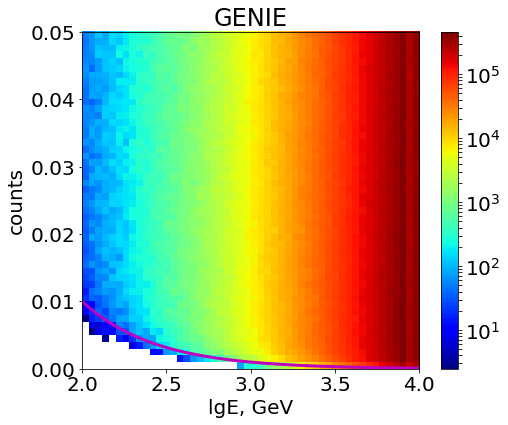

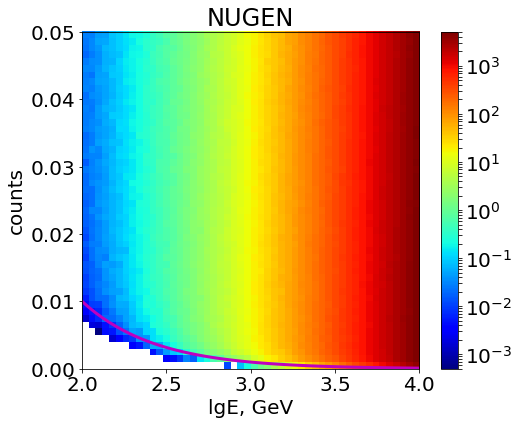

In [36]:
fig = plt.figure(1, figsize=(8, 6.2))

ax = plt.gca()
ax.set_aspect(2./0.05)
ax.set_title('GENIE')
ax.set_xlabel('lgE, GeV')
ax.set_ylabel('counts')

h1 = ax.hist2d(lgE_genie, Y_genie, nb, [[Emin, 4.],[0., 0.05]], weights=one_weight_genie,
         cmap='jet', norm=LogNorm())

e = h1[1]
plt.plot(e, 1./10**e, 'm', lw=3)
plt.colorbar(h1[3])
plt.show()

fig = plt.figure(1, figsize=(8, 6.2))

ax = plt.gca()
ax.set_aspect(2./0.05)
ax.set_title('NUGEN')
ax.set_xlabel('lgE, GeV')
ax.set_ylabel('counts')


h1 = ax.hist2d(lgE_nugen, Y_nugen, nb, [[Emin, 4.],[0., 0.05]], weights=one_weight_nugen,
         cmap='jet', norm=LogNorm())

plt.plot(e, 1./10**e, 'm', lw=3)
plt.colorbar(h1[3])
plt.show()

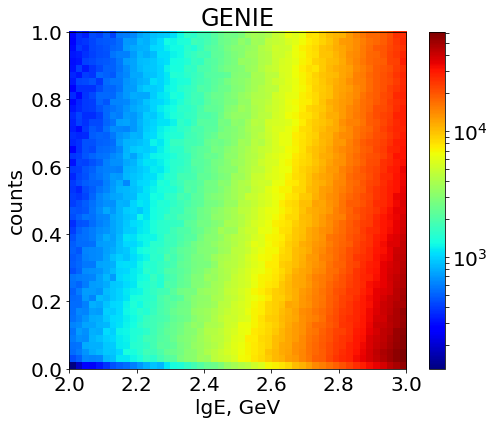

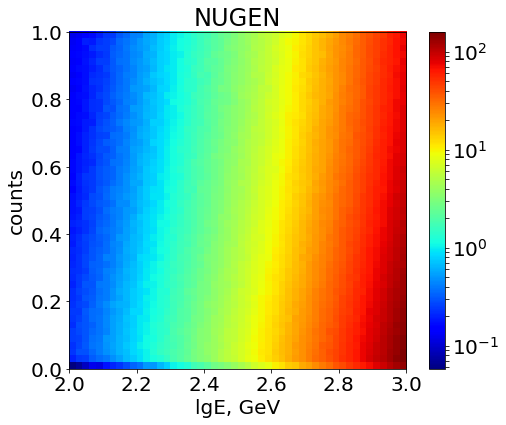

In [39]:
fig = plt.figure(1, figsize=(8, 6.2))

ax = plt.gca()
ax.set_aspect(1.)
ax.set_title('GENIE')
ax.set_xlabel('lgE, GeV')
ax.set_ylabel('counts')

h1 = ax.hist2d(lgE_genie, Y_genie, nb, [[Emin, 3.],[0., 1.]], weights=one_weight_genie,
         cmap='jet', norm=LogNorm())

plt.colorbar(h1[3])
plt.show()

fig = plt.figure(1, figsize=(8, 6.2))

ax = plt.gca()
ax.set_aspect(1.)
ax.set_title('NUGEN')
ax.set_xlabel('lgE, GeV')
ax.set_ylabel('counts')


h1 = ax.hist2d(lgE_nugen, Y_nugen, nb, [[Emin, 3.],[0., 1.]], weights=one_weight_nugen,
         cmap='jet', norm=LogNorm())

plt.colorbar(h1[3])
plt.show()